## Imports

In [3]:
import os
import sys 
import numpy as np
import pandas as pd
import glob
import xarray as xr  # For NetCDF file handling
from netCDF4 import Dataset  # Low-level NetCDF access if needed
from modflowapi import ModflowApi  # For MODFLOW 6 API interaction
import matplotlib.pyplot as plt  # For vis
from datetime import datetime  # For time
from osgeo import gdal
import numpy as np
from pyproj import Transformer


print(sys.version)
print(f"numpy version: {np.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3


## Paths

In [9]:
mf6_root = "../../MF6/"
#vic_root = "../../VIC/nmhydro-master/scripts/vic_classic_to_image/nm_image"
vic_root = "../../VIC/nm_image/"
global_param_file = os.path.join(vic_root, "global_param.txt")  ## vic global parameters file (it specifies all VIC I/O files)

## Functions

In [10]:
#########################################
##         READ VIC STATE FILE         ## 
#########################################

def read_vic_state(file_path=None, global_param_file=None, variables=None, verbose=False):
    """
    Read a VIC NetCDF state file into an xarray Dataset.
    
    Parameters:
    - file_path (str, optional): Direct path to the VIC state file. If None, derived from global_param_file.
    - global_param_file (str, optional): Path to VIC global parameter file to locate state file.
    - variables (list, optional): List of variable names to extract. If None, reads all variables.
    - verbose (bool, optional): If True, print the file path being read. Default is False.
    
    Returns:
    - xr.Dataset: VIC state data, or None if reading fails.
    
    Raises:
    - ValueError: If neither file_path nor global_param_file is provided, or if state file cannot be located.
    """
    # check if file path needs to be derived from global param file
    if file_path is None and global_param_file is not None:
        # initialize variables for state file details
        state_prefix = None
        state_year, state_month, state_day = None, None, None
        # open and read global param file
        with open(global_param_file, 'r') as f:
            # process each line in the file
            for line in f:
                # skip commented out lines
                if line.strip() and not line.startswith('#'):
                    # split line into parts
                    parts = line.split()
                    # extract state file prefix
                    if parts[0] == 'STATENAME': state_prefix = parts[1]  # set state file prefix
                    # extract year for state file
                    elif parts[0] == 'STATEYEAR': state_year = parts[1]  # set year
                    # extract month for state file
                    elif parts[0] == 'STATEMONTH': state_month = parts[1]  # set month
                    # extract day for state file
                    elif parts[0] == 'STATEDAY': state_day = parts[1]  # set day
        # ensure all required params are found
        if not all([state_prefix, state_year, state_month, state_day]):
            raise ValueError("Global parameter file missing required state file parameters (STATENAME, STATEYEAR, STATEMONTH, STATEDAY).")
        
        # get directory of global param file
        vic_root_dir = os.path.dirname(global_param_file)
        # format date as yyyymmdd
        state_date = f"{state_year}{state_month.zfill(2)}{state_day.zfill(2)}"
        # build base pattern for state file name (to avoid renaming the vic state file from e.g. 'state.20201231_00000.nc to 'state_20201231.nc' in my case.)
        base_pattern = os.path.join(vic_root_dir, f"{state_prefix}.{state_date}")
        # find files with timestamp or without
        possible_files = glob.glob(f"{base_pattern}*.nc") + glob.glob(f"{base_pattern}.nc") ## using glob for pattern matching
        # check if any matching files exist
        if not possible_files:
            raise ValueError(f"No state file found matching pattern: {base_pattern}[_timestamp].nc or {base_pattern}.nc")
        
        # pick first matching file
        file_path = possible_files[0]
        # print detected file verbose
        if verbose: print(f"Detected state file: {file_path}")

    elif file_path is None:
        raise ValueError("Must provide either file_path or global_param_file.")

    # attempt to read the state file
    try:
        # load netcdf file into dataset
        ds = xr.open_dataset(file_path)
        # subset to specific variables if provided
        if variables: ds = ds[variables]  # filter dataset by variables
        # print reading action if verbose
        if verbose: print(f"Reading VIC state file: {file_path}")
        # return the loaded dataset
        return ds
        
    except FileNotFoundError:
        print(f"Error: State file {file_path} not found.")  # notify user
        return None

    except Exception as e:
        print(f"Error reading state file: {e}")  # notify user of error
        return None


#########################################
##        WRITE VIC STATE FILE         ## 
#########################################

def write_vic_state(data, file_path=None, global_param_file=None, overwrite=False, verbose=False):
    """
    write a vic netcdf state file from an xarray dataset.
    
    parameters:
    - data (xr.Dataset): vic state data to write.
    - file_path (str, optional): direct path to save the state file. if none, derived from global_param_file.
    - global_param_file (str, optional): path to vic global parameter file to determine state file path.
    - overwrite (bool): if true, overwrite existing file. default is false.
    - verbose (bool, optional): if true, print actions performed. default is false.
    
    returns:
    - none
    
    raises:
    - ValueError: if neither file_path nor global_param_file is provided, or if required parameters are missing.
    - FileExistsError: if file exists and overwrite is false.
    """
    # check if path needs derivation
    if file_path is None and global_param_file is not None:
        # init state file vars
        state_prefix = None
        state_year, state_month, state_day = None, None, None
        # read global param file
        with open(global_param_file, 'r') as f:
            # process each line
            for line in f:
                # skip comments/empty lines
                if line.strip() and not line.startswith('#'):
                    # split into parts
                    parts = line.split()
                    # get state prefix
                    if parts[0] == 'STATENAME': state_prefix = parts[1]  # set prefix
                    # get year
                    elif parts[0] == 'STATEYEAR': state_year = parts[1]  # set year
                    # get month
                    elif parts[0] == 'STATEMONTH': state_month = parts[1]  # set month
                    # get day
                    elif parts[0] == 'STATEDAY': state_day = parts[1]  # set day
        # validate required params
        if not all([state_prefix, state_year, state_month, state_day]):
            raise ValueError("global parameter file missing required state file parameters (STATENAME, STATEYEAR, STATEMONTH, STATEDAY).")
        
        # get root directory
        vic_root_dir = os.path.dirname(global_param_file)
        # format date
        state_date = f"{state_year}{state_month.zfill(2)}{state_day.zfill(2)}"
        # set default vic file path
        file_path = os.path.join(vic_root_dir, f"{state_prefix}.{state_date}_00000.nc")
        # print path if verbose
        if verbose: print(f"using state file path: {file_path}")
    # error if no path
    elif file_path is None:
        raise ValueError("must provide either file_path or global_param_file.")

    # attempt to write file
    try:
        # check if file exists
        if os.path.exists(file_path) and not overwrite:
            raise FileExistsError(f"file {file_path} exists. set overwrite=True to replace it.")
        # save dataset to netcdf
        data.to_netcdf(file_path, mode='w')
        # confirm write if verbose
        if verbose: print(f"successfully wrote vic state file to {file_path}")
    # handle errors
    except Exception as e:
        print(f"error writing state file: {e}")

## Test reading New Mexico VIC state file

In [11]:
# Read the state file
state_ds = read_vic_state(global_param_file=global_param_file, verbose=True)

# Separate stats cell
if state_ds is not None:
    print(f"Number of variables: {len(state_ds.variables)}")
    if 'lat' in state_ds.coords and 'lon' in state_ds.coords:
        print(f"Unique lat/lon points: {len(state_ds['lat']) * len(state_ds['lon'])}")
    
    # Print list of all variables in three columns
    var_list = list(state_ds.variables.keys())
    print("\nVariables read from state file:")
    num_vars = len(var_list)
    col1_end = (num_vars + 2) // 3  # Ceiling division for balanced columns
    col2_end = (num_vars + 1) // 3 + col1_end
    
    col1 = var_list[:col1_end]
    col2 = var_list[col1_end:col2_end]
    col3 = var_list[col2_end:]
    
    # Pad shorter columns with empty strings for alignment
    max_len = max(len(col1), len(col2), len(col3))
    col1.extend([''] * (max_len - len(col1)))
    col2.extend([''] * (max_len - len(col2)))
    col3.extend([''] * (max_len - len(col3)))
    
    # Print in three columns
    for v1, v2, v3 in zip(col1, col2, col3):
        print(f"{v1:<25} {v2:<25} {v3:<25}")

Detected state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Reading VIC state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Number of variables: 28
Unique lat/lon points: 48124

Variables read from state file:
time                      STATE_SOIL_ICE            STATE_SNOW_PACK_WATER    
lon                       STATE_CANOPY_WATER        STATE_SNOW_DENSITY       
lat                       STATE_SNOW_AGE            STATE_SNOW_COLD_CONTENT  
veg_class                 STATE_SNOW_MELT_STATE     STATE_SNOW_CANOPY        
snow_band                 STATE_SNOW_COVERAGE       STATE_SOIL_NODE_TEMP     
layer                     STATE_SNOW_WATER_EQUIVALENT STATE_FOLIAGE_TEMPERATURE
frost_area                STATE_SNOW_SURF_TEMP      STATE_ENERGY_LONGUNDEROUT
dz_node                   STATE_SNOW_SURF_WATER     STATE_ENERGY_SNOW_FLUX   
node_depth                STATE_SNOW_PACK_TEMP      STATE_AVG_ALBEDO         
STATE_SOIL_MOISTURE                                            

## Test writing New Mexico# read the state file

In [5]:
state_ds = read_vic_state(global_param_file=global_param_file, verbose=True)
if state_ds is not None:
    modified_data = state_ds.copy()
    modified_data['STATE_SOIL_MOISTURE'] = (modified_data['STATE_SOIL_MOISTURE'] * 1.05).clip(max=1000)
    write_vic_state(
        data=modified_data,
        global_param_file=global_param_file,
        overwrite=True,
        verbose=True
    )
## although I ran chmod +rwx 

Detected state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Reading VIC state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
using state file path: ../../VIC/nm_image/outputs/state.20201231_00000.nc
error writing state file: [Errno 13] Permission denied: '/home/abd/projects/nmhydro/VIC/nm_image/outputs/state.20201231_00000.nc'


## Plot State Variables

Enter state variable names to plot (comma-separated, e.g., 'STATE_SOIL_MOISTURE'):  STATE_AVG_ALBEDO



Variable: STATE_AVG_ALBEDO
Shape: (227, 212)
Dimensions: ('lat', 'lon')
Stats for STATE_AVG_ALBEDO (full data, fraction):
Stats for STATE_AVG_ALBEDO (full data):
Mean: 0.29 fraction
Median: 0.19 fraction
Min: 0.10 fraction
Max: 1.00 fraction
Standard Deviation: 0.23 fraction
25th percentile: 0.19
50th percentile: 0.19
75th percentile: 0.20
90th percentile: 0.83


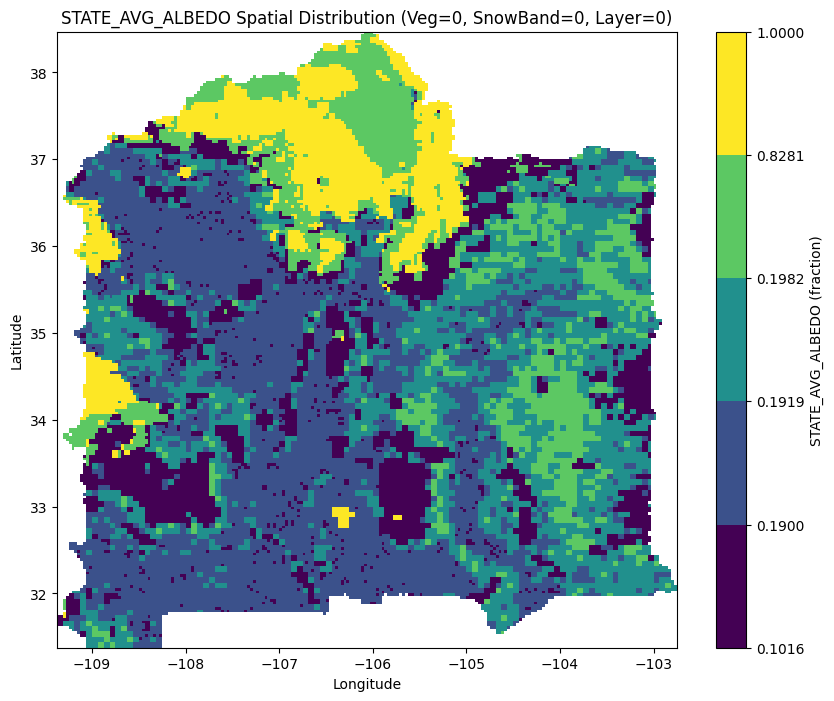

In [6]:
# Prompt user for variable names
var_input = input("Enter state variable names to plot (comma-separated, e.g., 'STATE_SOIL_MOISTURE'): ")
var_names = [v.strip() for v in var_input.split(',') if v.strip() in state_ds.variables]

if not var_names:
    print("No valid variable names provided or found in the dataset.")
else:
    for var_name in var_names:
        data = state_ds[var_name]
        
        ## print data shape and dimensions for debugging
        print(f"\nVariable: {var_name}")
        print(f"Shape: {data.shape}")
        print(f"Dimensions: {data.dims}")
        
        # Select a 2D slice for plotting
        if len(data.dims) > 2:
            if var_name == 'STATE_SOIL_MOISTURE':
                data_2d = data.isel(veg_class=0, snow_band=0, nlayer=0)  # first veg class, snow band, layer
            else:
                if 'time' in data.dims:
                    data_2d = data.isel(time=0)
                elif 'veg_class' in data.dims:
                    data_2d = data_2d.isel(veg_class=0)
                if 'snow_band' in data.dims:
                    data_2d = data_2d.isel(snow_band=0)
                if 'nlayer' in data.dims or 'layer' in data.dims:
                    data_2d = data_2d.isel(nlayer=0 if 'nlayer' in data.dims else 'layer')
            data_2d = data_2d.squeeze()
        else:
            data_2d = data
        
        # calculate stats and quantiles on the full data
        mean_val = float(data.mean().values)
        median_val = float(data.median().values)
        min_val = float(data.min().values)
        max_val = float(data.max().values)
        std_val = float(data.std().values)
        quantiles = data.quantile([0.25, 0.50, 0.75, 0.90]).values
        min_val = float(data.min().values)
        max_val = float(data.max().values)
        
        # Print stats (quantiles only)
        print(f"Stats for {var_name} (full data, {data.units}):")
        print(f"Stats for {var_name} (full data):")
        print(f"Mean: {mean_val:.2f} {data.units}")
        print(f"Median: {median_val:.2f} {data.units}")
        print(f"Min: {min_val:.2f} {data.units}")
        print(f"Max: {max_val:.2f} {data.units}")
        print(f"Standard Deviation: {std_val:.2f} {data.units}")
        
        print(f"25th percentile: {quantiles[0]:.2f}")
        print(f"50th percentile: {quantiles[1]:.2f}")
        print(f"75th percentile: {quantiles[2]:.2f}")
        print(f"90th percentile: {quantiles[3]:.2f}")
        
        # Check for lat/lon coordinates and plot
        if 'lat' in data_2d.coords and 'lon' in data_2d.coords:
            # Create GIS-style plot with quantile-based colormap
            plt.figure(figsize=(10, 8))
            lon, lat = np.meshgrid(data_2d['lon'], data_2d['lat'])
            
            # Define quantile boundaries for colormap
            from matplotlib.colors import BoundaryNorm
            levels = [min_val] + quantiles.tolist() + [max_val]  # Include min/max with quantiles
            norm = BoundaryNorm(levels, ncolors=256, clip=True)
            
            plt.pcolormesh(lon, lat, data_2d, cmap='viridis', norm=norm)
            plt.colorbar(label=f"{var_name} ({data.units})")
            plt.title(f"{var_name} Spatial Distribution (Veg=0, SnowBand=0, Layer=0)")
            plt.xlabel("Longitude")
            plt.ylabel("Latitude")
            plt.show()
        else:
            print(f"Cannot create GIS plot for {var_name}: 'lat' and 'lon' coordinates not found in 2D slice.")

## GRASS

In [7]:
def resample_state_variable(state_ds, variable_name, target_resolution_m, output_file=None, 
                           grass_db="./grass", grass_location="vic_project", 
                           gisbase="~/usr/local/src/grass", verbose=False):
    """
    resample a vic state variable to a specified resolution using grass gis bilinear interpolation.
    
    parameters:
    - state_ds (xr.Dataset): vic state dataset containing the variable to resample.
    - variable_name (str): name of the state variable to resample (e.g., 'STATE_SOIL_MOISTURE').
    - target_resolution_m (float): target resolution in meters (e.g., 201 for 660 ft).
    - output_file (str, optional): path to save the resampled netcdf file. if none, uses default naming.
    - grass_db (str): grass database directory (default: './grass/').
    - grass_location (str): grass location name (default: 'vic_project').
    - gisbase (str): path to grass installation (default: '~/usr/local/src/grass').
    - verbose (bool): if true, print processing steps. default is false.
    
    returns:
    - str: path to the resampled output file, or none if failed.
    
    raises:
    - ValueError: if variable_name not in state_ds or grass setup fails.
    """

    # expand user path and set grass environment
    gisbase = os.path.expanduser(gisbase)
    os.environ["GISBASE"] = gisbase
    
    # add grass python libs to sys.path (corrected path)
    grass_lib_path = os.path.join(gisbase, "python")
    if grass_lib_path not in sys.path:
        sys.path.append(grass_lib_path)
    
    # attempt to import grass modules
    try:
        import grass.script as gs
        import grass.script.setup as gsetup
    except ModuleNotFoundError:
        print(f"error: grass python modules not found in {grass_lib_path}. ensure grass is installed with python support.")
        return None
    
    # check if grass executable exists
    grass_bin = os.path.join(gisbase, "bin", "grass")
    if not os.path.exists(grass_bin):
        print(f"error: grass executable not found at {grass_bin}. check gisbase path.")
        return None
    
    # validate input
    if variable_name not in state_ds.variables:
        raise ValueError(f"variable '{variable_name}' not found in state dataset.")
    if 'lat' not in state_ds.coords or 'lon' not in state_ds.coords:
        raise ValueError("state dataset must have 'lat' and 'lon' coordinates.")

    # set default output file if not provided
    if output_file is None:
        output_file = os.path.abspath(f"resampled_{variable_name}_{target_resolution_m}m.nc")
    if verbose:
        print(f"output file set to: {output_file}")

    # extract variable slice (first non-spatial dims if multi-dimensional)
    var_data = state_ds[variable_name]
    if len(var_data.dims) > 2:
        # assume first indices for non-lat/lon dims (e.g., veg_class=0, snow_band=0, nlayer=0)
        slice_dict = {dim: 0 for dim in var_data.dims if dim not in ['lat', 'lon']}
        var_data = var_data.isel(**slice_dict)
    if verbose:
        print(f"processing 2d slice of {variable_name} with shape: {var_data.shape}")

    # save temporary netcdf for grass import
    temp_file = "temp_slice.nc"
    var_data.to_netcdf(temp_file)

    # grass setup
    gisdb = os.path.abspath(grass_db)
    mapset = "PERMANENT"
    
    # create grass location if it doesn’t exist (first run)
    location_path = os.path.join(gisdb, grass_location)
    if not os.path.exists(location_path):
        if verbose:
            print(f"creating new grass location at: {location_path}")
        try:
            gs.run_command("grass", flags="c", georef=temp_file, location=grass_location,
                          gisdbase=gisdb, quiet=not verbose)
        except Exception as e:
            print(f"error creating grass location: {e}")
            print("hint: ensure grass is built with python support (e.g., ./configure --with-python)")
            os.remove(temp_file)
            return None
    elif verbose:
        print(f"using existing grass location: {location_path}")

    # initialize grass session
    try:
        gsetup.init(gisbase, gisdb, grass_location, mapset)
    except Exception as e:
        print(f"error initializing grass session: {e}")
        os.remove(temp_file)
        return None

    # set region to vic bounds
    gs.run_command("g.region", n=float(state_ds.lat.max()), s=float(state_ds.lat.min()),
                   e=float(state_ds.lon.max()), w=float(state_ds.lon.min()), 
                   res=0.0083333, quiet=not verbose)  # ~1 km original res

    # import temporary netcdf
    raw_map = f"{variable_name}_raw"
    gs.run_command("r.in.gdal", input=temp_file, output=raw_map, band=1,
                   overwrite=True, quiet=not verbose)

    # calculate resolution in degrees (approx, assumes lat/lon)
    lat_range = float(state_ds.lat.max() - state_ds.lat.min())
    meters_per_degree = 111000  # rough avg for lat/lon (111 km/degree)
    target_res_deg = target_resolution_m / meters_per_degree
    if verbose:
        print(f"target resolution: {target_resolution_m} m ≈ {target_res_deg:.6f} degrees")

    # set target resolution
    gs.run_command("g.region", res=target_res_deg, align=raw_map, quiet=not verbose)

    # perform bilinear interpolation
    resampled_map = f"{variable_name}_{target_resolution_m}m"
    gs.run_command("r.resamp.interp", input=raw_map, output=resampled_map,
                   method="bilinear", overwrite=True, quiet=not verbose)

    # export to netcdf
    gs.run_command("r.out.gdal", input=resampled_map, output=output_file,
                   format="NetCDF", overwrite=True, quiet=not verbose)

    # clean up temporary file
    os.remove(temp_file)
    if verbose:
        print(f"resampling complete. output saved to: {output_file}")

    return output_file

In [8]:
state_ds = read_vic_state(global_param_file=global_param_file, verbose=True)
if state_ds is not None:
    resampled_file = resample_state_variable(
        state_ds=state_ds,
        variable_name="STATE_SOIL_MOISTURE",
        target_resolution_m=201,  # 660 ft
        gisbase="~/usr/local/src/grass",  # Your GRASS path
        verbose=True
    )
    if resampled_file:
        print(f"Resampled file ready at: {resampled_file}")

Detected state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Reading VIC state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
error: grass executable not found at /home/abd/usr/local/src/grass/bin/grass. check gisbase path.


## GDAL

In [12]:
def resample_state_variable(state_ds, variable_name, target_resolution_m, output_file=None, verbose=False):
    """
    resample a vic state variable to a specified resolution using gdal bilinear interpolation (epsg:4269 only).
    
    parameters:
    - state_ds (xr.Dataset): vic state dataset containing the variable to resample.
    - variable_name (str): name of the state variable to resample (e.g., 'STATE_SOIL_MOISTURE').
    - target_resolution_m (float): target resolution in meters (e.g., 201 for 660 ft).
    - output_file (str, optional): path to save the resampled netcdf file. if none, uses default naming.
    - verbose (bool): if true, print processing steps. default is false.
    
    returns:
    - str: path to the resampled output file, or none if failed.
    
    raises:
    - ValueError: if variable_name not in state_ds or coordinates missing.
    """
    import os
    from osgeo import gdal
    import numpy as np
    
    # validate input
    if variable_name not in state_ds.variables:
        raise ValueError(f"variable '{variable_name}' not found in state dataset.")
    if 'lat' not in state_ds.coords or 'lon' not in state_ds.coords:
        raise ValueError("state dataset must have 'lat' and 'lon' coordinates.")

    # set default output file if not provided
    if output_file is None:
        output_file = os.path.abspath(f"resampled_{variable_name}_{target_resolution_m}m.nc")
    if verbose:
        print(f"output file set to: {output_file}")

    # extract variable slice (first non-spatial dims if multi-dimensional)
    var_data = state_ds[variable_name]
    if len(var_data.dims) > 2:
        slice_dict = {dim: 0 for dim in var_data.dims if dim not in ['lat', 'lon']}
        var_data = var_data.isel(**slice_dict)
    if verbose:
        print(f"processing 2d slice of {variable_name} with shape: {var_data.shape}")

    # save temporary netcdf for gdal processing
    temp_file = "temp_slice.nc"
    var_data.to_netcdf(temp_file)

    # hardcode crs to epsg:4269 (nad83 lat/lon)
    src_epsg = 4269
    if verbose:
        print(f"using hardcoded crs: epsg:{src_epsg} (nad83 lat/lon)")

    # calculate centroid latitude for resolution conversion
    lat_center = float(np.mean(state_ds.lat))
    if verbose:
        print(f"centroid latitude: {lat_center:.4f}")

    # convert meters to degrees for epsg:4269 (nad83 lat/lon)
    meters_per_deg_lat = 111320  # approx constant for latitude (nad83 similar to wgs84)
    meters_per_deg_lon = 111320 * np.cos(np.radians(lat_center))  # adjust longitude by latitude
    target_res_deg_lat = target_resolution_m / meters_per_deg_lat
    target_res_deg_lon = target_resolution_m / meters_per_deg_lon
    if verbose:
        print(f"meters/deg lat: {meters_per_deg_lat:.0f}, lon: {meters_per_deg_lon:.0f}")
        print(f"target res: lat={target_res_deg_lat:.6f} deg, lon={target_res_deg_lon:.6f} deg")

    # perform resampling with gdalwarp
    try:
        gdal.Warp(
            destNameOrDestDS=output_file,
            srcDSOrSrcDSTab=temp_file,
            format="NetCDF",
            xRes=target_res_deg_lon,  # longitude
            yRes=target_res_deg_lat,  # latitude
            resampleAlg=gdal.GRA_Bilinear,
            dstNodata=None,
            srcSRS="EPSG:4269",
            dstSRS="EPSG:4269"
        )
        if verbose:
            print(f"resampling complete. output saved to: {output_file}")
    except Exception as e:
        print(f"error during gdal resampling: {e}")
        os.remove(temp_file)
        return None

    # clean up temporary file
    os.remove(temp_file)
    return output_file

In [13]:
state_ds = read_vic_state(global_param_file=global_param_file, verbose=True)
if state_ds is not None:
    resampled_file = resample_state_variable(
        state_ds=state_ds,
        variable_name="STATE_SOIL_MOISTURE",
        target_resolution_m=201,  # rgtihm resolution = 660ft x 660 (~201m x 201m)
        verbose=True
    )
    if resampled_file:
        print(f"Resampled file ready at: {resampled_file}")

Detected state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Reading VIC state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
output file set to: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc
processing 2d slice of STATE_SOIL_MOISTURE with shape: (227, 212)
using hardcoded crs: epsg:4269 (nad83 lat/lon)
centroid latitude: 34.9219
meters/deg lat: 111320, lon: 91275
target res: lat=0.001806 deg, lon=0.002202 deg
resampling complete. output saved to: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc
Resampled file ready at: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc


## Sample Raster Values 
read VIC state variable values in the MF6 grid points

In [20]:
def sample_vic_at_mf6_locations(resampled_file, variable_name, mf6_root, verbose=False):
    """
    sample vic resampled raster values at active mf6 grid locations (idomain=1) using gdal.
    
    parameters:
    - resampled_file (str): path to the resampled vic netcdf file.
    - variable_name (str): name of the vic state variable (e.g., 'STATE_SOIL_MOISTURE').
    - mf6_root (str): path to the mf6 model directory (e.g., '../../MF6/').
    - verbose (bool): if true, print processing steps. default is false.
    
    returns:
    - pd.DataFrame: dataframe with lat, lon, and sampled vic values for active mf6 cells.
    """
    import os
    from osgeo import gdal
    import geopandas as gpd
    import pandas as pd
    import numpy as np
    from pyproj import Transformer
    
    # use mf6_root from notebook paths; assume grid.gpkg is in rgtihm/shps/ subdirectory
    grid_file = os.path.join(mf6_root, "rgtihm", "shps", "grid.gpkg")
    if not os.path.exists(grid_file):
        raise FileNotFoundError(f"mf6 grid file not found at: {grid_file}")

    # read mf6 grid (layer 1 because UZF is applied to botm layer 0)
    if verbose:
        print(f"reading mf6 grid from: {grid_file}")
    gdf = gpd.read_file(grid_file, layer=1)  # layer 1 for top layer (GPKG indexing)
    
    # filter for active cells (idomain == 1)
    if 'idomain' not in gdf.columns:
        raise ValueError("mf6 grid missing 'idomain' column.")
    active_gdf = gdf[gdf['idomain'] == 1].copy()
    if verbose:
        print(f"found {len(active_gdf)} active cells (idomain=1)")

    # get centroids in original crs (assuming epsg:26913, nad83 utm zone 13n)
    active_gdf['x'] = active_gdf.geometry.centroid.x
    active_gdf['y'] = active_gdf.geometry.centroid.y
    if verbose:
        print(f"extracted x/y centroids in original crs")

    # transform to epsg:4269 (nad83 lat/lon) to match vic raster
    transformer = Transformer.from_crs("epsg:26913", "epsg:4269", always_xy=True)
    active_gdf['lon'], active_gdf['lat'] = transformer.transform(active_gdf['x'].values, active_gdf['y'].values)
    if verbose:
        print(f"transformed centroids to epsg:4269 (lat/lon)")

    # open resampled vic raster with gdal
    if not os.path.exists(resampled_file):
        raise FileNotFoundError(f"resampled vic file not found at: {resampled_file}")
    dataset = gdal.Open(resampled_file)
    if dataset is None:
        raise ValueError(f"failed to open resampled vic raster: {resampled_file}")
    if verbose:
        print(f"opened resampled vic raster: {resampled_file}")

    # get raster geotransform and dimensions
    geotransform = dataset.GetGeoTransform()
    band = dataset.GetRasterBand(1)  # assuming single band from resampled 2d slice
    raster_array = band.ReadAsArray()
    nodata = band.GetNoDataValue()
    if verbose:
        print(f"raster shape: {raster_array.shape}, nodata value: {nodata}")

    # convert lat/lon to pixel coordinates
    x_origin, x_pixel_size, _, y_origin, _, y_pixel_size = geotransform
    sampled_values = []
    for lon, lat in zip(active_gdf['lon'], active_gdf['lat']):
        # transform geographic coords to pixel coords
        x_pixel = int((lon - x_origin) / x_pixel_size)
        y_pixel = int((lat - y_origin) / y_pixel_size)
        
        # check bounds
        if 0 <= x_pixel < raster_array.shape[1] and 0 <= y_pixel < raster_array.shape[0]:
            value = raster_array[y_pixel, x_pixel]
            sampled_values.append(value if value != nodata else np.nan)
        else:
            sampled_values.append(np.nan)  # out of bounds
    if verbose:
        print(f"sampled {len(sampled_values)} values from vic raster")

    # build dataframe
    df = pd.DataFrame({
        'lat': active_gdf['lat'],
        'lon': active_gdf['lon'],
        variable_name: sampled_values
    })
    if verbose:
        print(f"created dataframe with columns: {df.columns.tolist()}")

    # close dataset
    dataset = None
    return df

# Example usage integrating with resample_state_variable and notebook paths
mf6_root = "../../MF6/"  # from your paths cell
vic_root = "../../VIC/nm_image/"  # from your paths cell
global_param_file = os.path.join(vic_root, "global_param.txt")  # from your paths cell

state_ds = read_vic_state(global_param_file=global_param_file, verbose=True)
if state_ds is not None:
    resampled_file = resample_state_variable(
        state_ds=state_ds,
        variable_name="STATE_SOIL_MOISTURE",
        target_resolution_m=201,  # 660 ft ≈ 201 m
        verbose=True
    )
    if resampled_file:
        df = sample_vic_at_mf6_locations(
            resampled_file=resampled_file,
            variable_name="STATE_SOIL_MOISTURE",
            mf6_root=mf6_root,
            verbose=True
        )
        if df is not None:
            print("Sampled DataFrame head:")
            print(df.head())
            # Fix NameError by using the variable_name parameter
            variable_name = "STATE_SOIL_MOISTURE"  ## define it here too, (idk why but it gives you an error that variable name is not defined)
            df.to_csv(f"mf6_{variable_name}_sampled.csv", index=False)

Detected state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
Reading VIC state file: ../../VIC/nm_image/outputs/state.20201231_00000.nc
output file set to: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc
processing 2d slice of STATE_SOIL_MOISTURE with shape: (227, 212)
using hardcoded crs: epsg:4269 (nad83 lat/lon)
centroid latitude: 34.9219
meters/deg lat: 111320, lon: 91275
target res: lat=0.001806 deg, lon=0.002202 deg
resampling complete. output saved to: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc
reading mf6 grid from: ../../MF6/rgtihm/shps/grid.gpkg
found 17879 active cells (idomain=1)
extracted x/y centroids in original crs
transformed centroids to epsg:4269 (lat/lon)
opened resampled vic raster: /home/abd/projects/nmhydro/coupling/VIC-MF6/resampled_STATE_SOIL_MOISTURE_201m.nc
raster shape: (3929, 3008), nodata value: 9.969209968386869e+36
sampled 17879 values from vic raster
created dataframe wi